# Heat equation

## imports

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from IPython.display import HTML
from scipy import special
import math

## initialization

In [80]:
X_max = 100
Y_max = 100
X_min = Y_min = 0

NUMBER_X = 120
NUMBER_Y = 90

In [81]:
X_RANGE = np.linspace(X_min, X_max, NUMBER_X)
Y_RANGE = np.linspace(Y_min, Y_max, NUMBER_Y)

X_STEP = X_RANGE[1] - X_RANGE[0]
Y_STEP = Y_RANGE[1] - Y_RANGE[0]

In [82]:
X, Y = np.meshgrid(X_RANGE, Y_RANGE, indexing='ij')

T = np.zeros_like(X)
lambdas = np.ones_like(X)
source_c = np.zeros_like(X) 
source_p = np.zeros_like(X)

In [83]:
def calculate_coefficients(alpha, beta, current_u, upper_u, lower_u, s, current_lambdas, upper_lambdas, lower_lambdas, kind):
    """makes Thomas algorithm for longituginal and transversal kinds"""
    if kind == 'longituginal':
        size_x = X_STEP
        size_y = Y_STEP
        
    elif kind == 'transversal':
        size_x = Y_STEP
        size_y = X_STEP

    a  = np.roll(current_lambdas, 1) / (np.roll(current_lambdas, 1) + current_lambdas) / size_x ** 2
    b  = np.roll(current_lambdas, -1) / (np.roll(current_lambdas, -1) + current_lambdas) / size_x ** 2
    c = (
        ((np.roll(current_lambdas, -1) + np.roll(current_lambdas, 1)) * current_lambdas + 
        2 * np.roll(current_lambdas, -1) * np.roll(current_lambdas, 1)) /
        (np.roll(current_lambdas, -1) + current_lambdas) / 
        (np.roll(current_lambdas, 1) + current_lambdas) /
        size_x ** 2 +
        ((upper_lambdas + lower_lambdas) * current_lambdas + 
        2 * upper_lambdas * lower_lambdas) /
        (upper_lambdas + current_lambdas) / 
        (lower_lambdas + current_lambdas) /
        size_y ** 2
    )
    d = (
        upper_lambdas / (upper_lambdas + current_lambdas)
        * upper_u / size_y ** 2 + 
        lower_lambdas / (lower_lambdas + current_lambdas)
        * lower_u / size_y ** 2 -
        s / (2 * current_lambdas)
    )

    for i in range(1, len(current_u)-1):
        alpha[i+1] = b[i] / (c[i] - alpha[i] * a[i])
        beta[i+1] = (a[i] * beta[i] + d[i]) / (c[i] - alpha[i] * a[i])
        
    return alpha, beta
    
def thomas_algorithm_trans(U, S, lambdas):
    
    for k in range(1, len(U[1,:]) - 1):  
        
        lambdas, U = first_area(lambdas, U)
        
        current_u = U[:, k]
        upper_u = U[:, k+1]
        lower_u = U[:, k-1]
        
        s = S[:, k]
        
        current_lambdas = lambdas[:, k]
        upper_lambdas = lambdas[:, k+1]
        lower_lambdas = lambdas[:, k-1]
        
        alpha = np.zeros_like(current_u)
        beta = np.zeros_like(current_u)

        alpha[1] = 0
        beta[1] = Q_LEFT * X_STEP / current_lambdas[0]
        

        
        kind = 'transversal'
        alpha, beta = calculate_coefficients(alpha, beta, current_u, upper_u, lower_u, s, 
                                             current_lambdas, upper_lambdas, lower_lambdas, kind)
        
        U[-1, k] = T_RIGHT
        
        for m in reversed(range(0, len(U[:, 1]) - 1)):
            U[m, k] = alpha[m+1] * U[m+1, k] + beta[m+1]
            
    return U

def thomas_algorithm_long(U, S, lambdas):
    for m in range(1, len(U[:, 1]) - 1):
                
        lambdas, U = first_area(lambdas, U)

        current_u = U[m, :]
        upper_u = U[m+1, :]
        lower_u = U[m-1, :]

        s = S[m, :]

        current_lambdas = lambdas[m, :]
        upper_lambdas = lambdas[m+1, :]
        lower_lambdas = lambdas[m-1, :]

        alpha = np.zeros_like(current_u)
        beta = np.zeros_like(current_u)

        alpha[1] = 0
        beta[1] = T_LOWER


        kind = 'longituginal'
        alpha, beta = calculate_coefficients(alpha, beta, current_u, upper_u, lower_u, s, 
                                             current_lambdas, upper_lambdas, lower_lambdas, kind)
        
        U[m, -1] = (Y_STEP * Q_UPPER / current_lambdas[-1] + beta[-1]) / (1 - alpha[-1])

        for k in reversed(range(0, len(U[1,:]) - 1)):
            U[m, k] = alpha[k+1] * U[m, k+1] + beta[k+1]

    return U
    
def heatmap2d(arr: np.ndarray):
    plt.imshow(arr.T, cmap='hot', interpolation='sinc')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Temperature map')
    ax = plt.gca()
    ax.invert_yaxis()

## boundary conditions

<img src="task3.png">

### outlet conditions

In [84]:
T_LOWER = 0         # lower bound
Q_UPPER = 5         # upper bound
Q_LEFT = 0          # left bound
T_RIGHT = 200      # right bound

T[-1,:] = T_RIGHT

### 1

In [85]:
def first_area(lambdas, U):
    T_edge = 100
    lambda_edge = 10 ** 20

    bound_size_x = 30
    bound_size_y = 20

    lambdas[0 : bound_size_x, 0 : bound_size_y] = lambda_edge
    U[0 : bound_size_x, 0] = T_edge
    U[0 : bound_size_x, bound_size_y] = T_edge
    U[0, 0 : bound_size_y] = T_edge
    U[bound_size_x, 0 : bound_size_y] = T_edge
    return lambdas, U

## main procedure

In [86]:
check = True

In [87]:
while check:
    T_prev = T.copy()
    
    T = thomas_algorithm_trans(T, source_c, lambdas)
    T = thomas_algorithm_long(T, source_c, lambdas)
    
    T_difference = abs(T_prev - T)
    
    if np.amax(T_difference) < 0.1:
        check = False

## vizualization

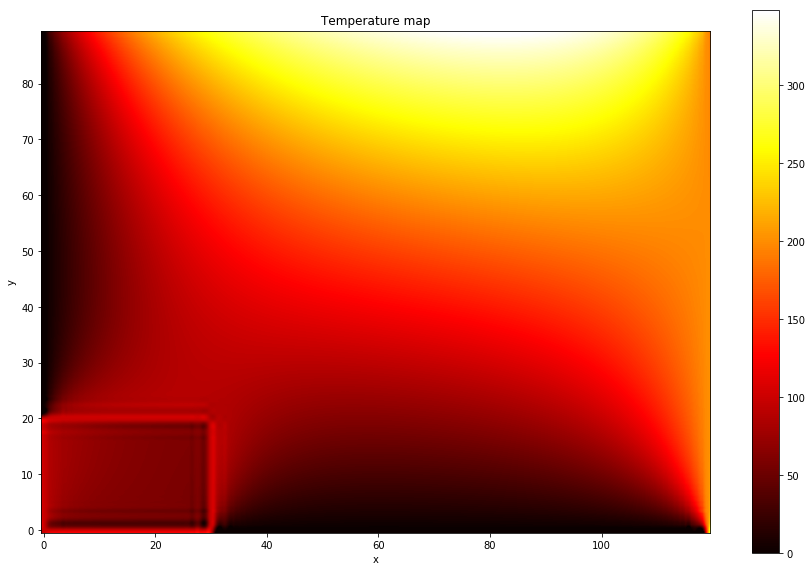

In [88]:
fig, ax = plt.subplots(figsize=(15,10))
heatmap2d(T)